# Model Results Visualization

This notebook visualizes the segmentation results from trained models on the SpectralWaste dataset.

## 1. Setup and Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from spectralwaste_segmentation import models, datasets, utils

## 2. Configuration

In [ ]:
# Paths
DATA_PATH = 'D:\Data\spectralwaste-segmentation-data\spectralwaste_segmentation'  # Update this path to your dataset location
MODEL_PATH = '../scripts/results/cmx_b0.rgb,hyper.labels_rgb.6752.best.pth' # Update this path to your model location

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 3. Load Model and Dataset

In [5]:
# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
args = checkpoint['args']

print("Model configuration:")
print(f"  Model: {args.model}")
print(f"  Input mode: {args.input_mode}")
print(f"  Target mode: {args.target_mode}")

# Load dataset
test_data = datasets.SpectralWasteSegmentation(
    DATA_PATH, 
    split='test', 
    input_mode=args.input_mode, 
    target_mode=args.target_mode, 
    target_type=''
)

print(f"\nDataset info:")
print(f"  Test samples: {len(test_data)}")
print(f"  Number of classes: {test_data.num_classes}")
print(f"  Classes: {test_data.classes_names}")

# Create and load model
model = models.create_model(args.model, test_data.num_channels, test_data.num_classes)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

print("\nModel loaded successfully!")

Model configuration:
  Model: cmx_b0
  Input mode: ['rgb', 'hyper']
  Target mode: labels_rgb

Dataset info:
  Test samples: 171
  Number of classes: 7
  Classes: ['background', 'film', 'basket', 'cardboard', 'video_tape', 'filament', 'bag']

Model loaded successfully!


## 4. Visualize Single Prediction

In [6]:
def predict_and_visualize(model, data, idx, device='cpu'):
    """
    Run inference on a single sample and visualize the results.
    
    Args:
        model: The segmentation model
        data: The dataset
        idx: Index of the sample to visualize
        device: Device to run inference on
    """
    with torch.inference_mode():
        input_data, target = data[idx][0], data[idx][1]
        
        # Prepare input
        if isinstance(input_data, list):
            input_tensor = [i.unsqueeze(0).to(device) for i in input_data]
            rgb_image = input_data[0]  # First input is typically RGB
        else:
            input_tensor = input_data.unsqueeze(0).to(device)
            rgb_image = input_data if input_data.shape[0] == 3 else None
        
        # Run inference
        output = model(input_tensor)
        prediction = output.argmax(dim=1).squeeze().cpu()
    
    # Create visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Input image (RGB)
    if rgb_image is not None:
        axs[0].imshow(rgb_image.permute(1, 2, 0))
        axs[0].set_title('Input Image (RGB)', fontsize=12)
    else:
        axs[0].text(0.5, 0.5, 'RGB not available', ha='center', va='center')
        axs[0].set_title('Input Image', fontsize=12)
    axs[0].axis('off')
    
    # Ground truth
    axs[1].imshow(utils.get_color_labels(target, data.palette), interpolation='none')
    axs[1].set_title('Ground Truth', fontsize=12)
    axs[1].axis('off')
    
    # Prediction
    axs[2].imshow(utils.get_color_labels(prediction, data.palette), interpolation='none')
    axs[2].set_title('Prediction', fontsize=12)
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return prediction, target

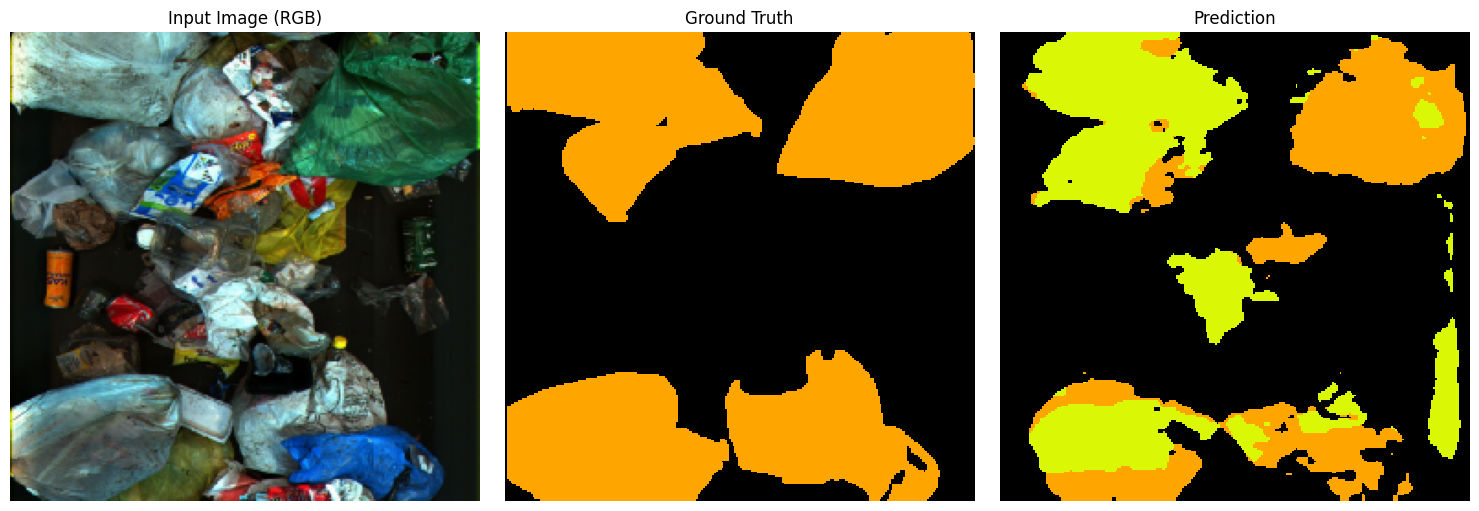

In [7]:
# Visualize a single sample
sample_idx = 0  # Change this to visualize different samples
prediction, target = predict_and_visualize(model, test_data, sample_idx, device)

## 5. Visualize Multiple Predictions

In [8]:
def visualize_multiple_predictions(model, data, indices, device='cpu'):
    """
    Visualize predictions for multiple samples in a grid.
    
    Args:
        model: The segmentation model
        data: The dataset
        indices: List of sample indices to visualize
        device: Device to run inference on
    """
    n_samples = len(indices)
    fig, axs = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))
    
    if n_samples == 1:
        axs = axs.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        with torch.inference_mode():
            input_data, target = data[idx][0], data[idx][1]
            
            # Prepare input
            if isinstance(input_data, list):
                input_tensor = [inp.unsqueeze(0).to(device) for inp in input_data]
                rgb_image = input_data[0]
            else:
                input_tensor = input_data.unsqueeze(0).to(device)
                rgb_image = input_data if input_data.shape[0] == 3 else None
            
            # Run inference
            output = model(input_tensor)
            prediction = output.argmax(dim=1).squeeze().cpu()
        
        # Plot RGB input
        if rgb_image is not None:
            axs[i, 0].imshow(rgb_image.permute(1, 2, 0))
        axs[i, 0].axis('off')
        if i == 0:
            axs[i, 0].set_title('Input Image', fontsize=14, fontweight='bold')
        
        # Plot ground truth
        axs[i, 1].imshow(utils.get_color_labels(target, data.palette), interpolation='none')
        axs[i, 1].axis('off')
        if i == 0:
            axs[i, 1].set_title('Ground Truth', fontsize=14, fontweight='bold')
        
        # Plot prediction
        axs[i, 2].imshow(utils.get_color_labels(prediction, data.palette), interpolation='none')
        axs[i, 2].axis('off')
        if i == 0:
            axs[i, 2].set_title('Prediction', fontsize=14, fontweight='bold')
        
        # Add sample index label
        axs[i, 0].text(-0.1, 0.5, f'Sample {idx}', 
                       transform=axs[i, 0].transAxes,
                       fontsize=12, va='center', ha='right', rotation=90)
    
    plt.tight_layout()
    plt.show()

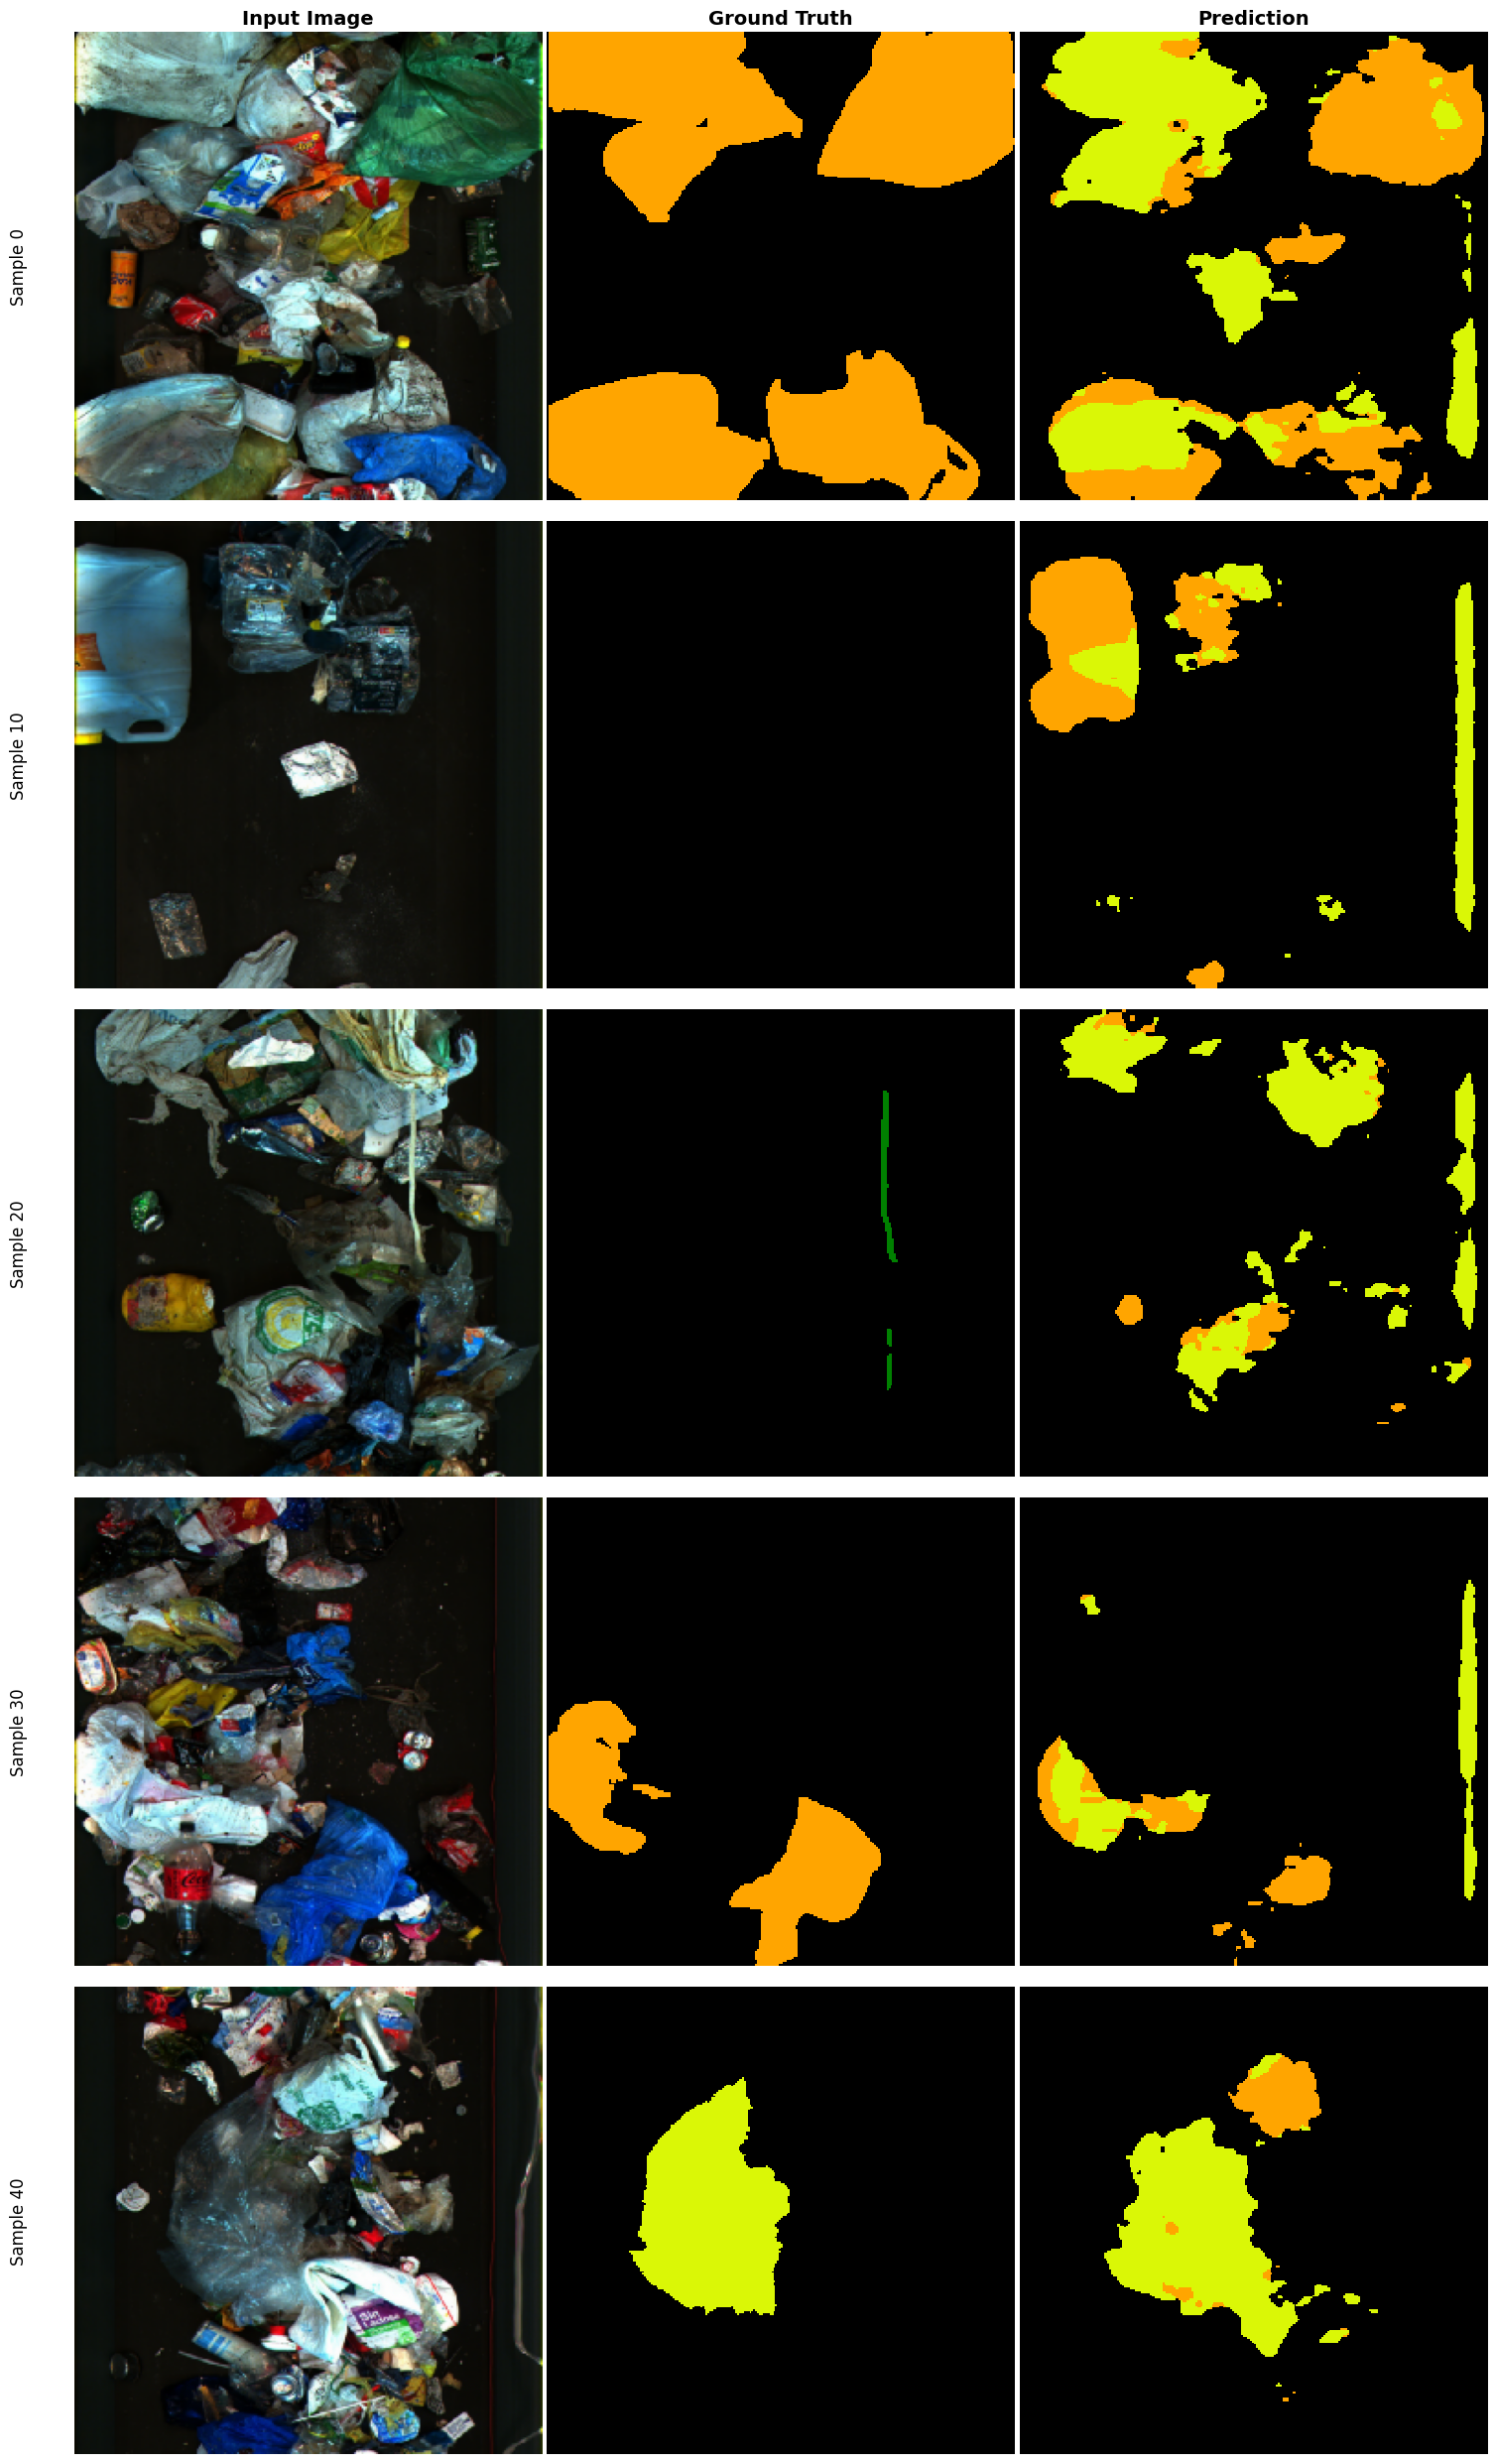

In [9]:
# Visualize multiple samples
sample_indices = [0, 10, 20, 30, 40]  # Change these indices as needed
visualize_multiple_predictions(model, test_data, sample_indices, device)

## 6. Class Distribution Analysis

In [10]:
def analyze_class_distribution(prediction, target, class_names):
    """
    Analyze and visualize class distribution in prediction vs ground truth.
    
    Args:
        prediction: Predicted segmentation mask
        target: Ground truth segmentation mask
        class_names: List of class names
    """
    unique_pred, counts_pred = torch.unique(prediction, return_counts=True)
    unique_target, counts_target = torch.unique(target, return_counts=True)
    
    # Calculate percentages
    total_pixels = prediction.numel()
    
    pred_percentages = {}
    for cls, count in zip(unique_pred.tolist(), counts_pred.tolist()):
        pred_percentages[cls] = (count / total_pixels) * 100
    
    target_percentages = {}
    for cls, count in zip(unique_target.tolist(), counts_target.tolist()):
        target_percentages[cls] = (count / total_pixels) * 100
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Ground truth distribution
    classes = list(target_percentages.keys())
    values_target = [target_percentages[c] for c in classes]
    labels = [class_names[c] if c < len(class_names) else f'Class {c}' for c in classes]
    
    ax1.bar(labels, values_target, color='steelblue', alpha=0.7)
    ax1.set_title('Ground Truth Class Distribution', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Percentage (%)', fontsize=11)
    ax1.set_xlabel('Class', fontsize=11)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Prediction distribution
    classes = list(pred_percentages.keys())
    values_pred = [pred_percentages[c] for c in classes]
    labels = [class_names[c] if c < len(class_names) else f'Class {c}' for c in classes]
    
    ax2.bar(labels, values_pred, color='coral', alpha=0.7)
    ax2.set_title('Prediction Class Distribution', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Percentage (%)', fontsize=11)
    ax2.set_xlabel('Class', fontsize=11)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return pred_percentages, target_percentages

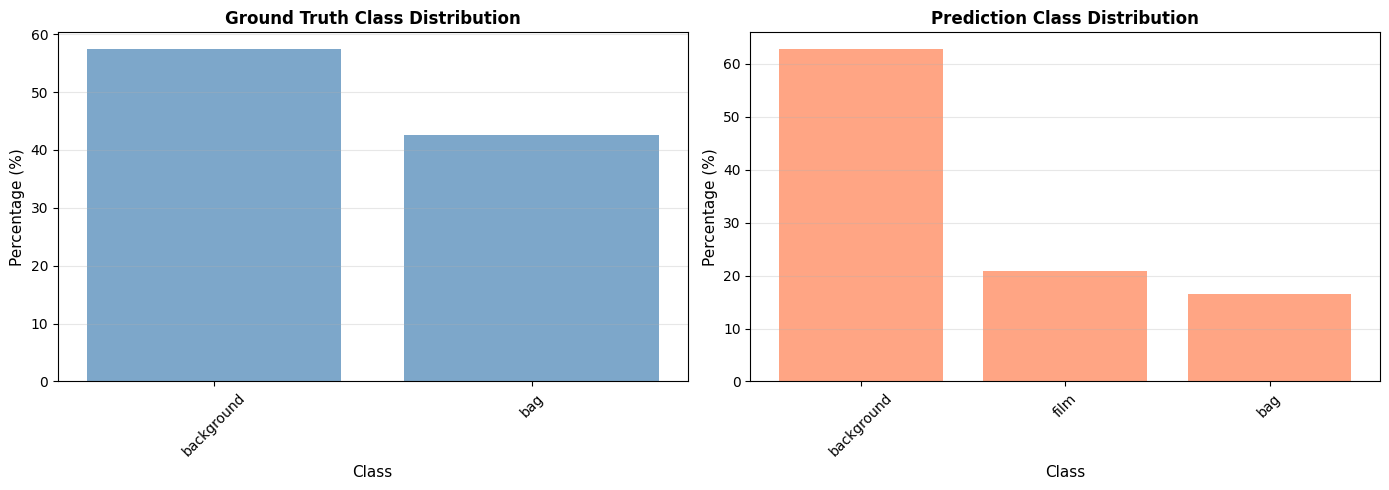

In [11]:
# Analyze class distribution for the current sample
pred_dist, target_dist = analyze_class_distribution(prediction, target, test_data.classes_names)

## 7. Calculate Metrics

In [12]:
def calculate_metrics(prediction, target, num_classes):
    """
    Calculate segmentation metrics: IoU and pixel accuracy.
    
    Args:
        prediction: Predicted segmentation mask
        target: Ground truth segmentation mask
        num_classes: Number of classes
    """
    # Pixel accuracy
    correct = (prediction == target).sum().item()
    total = target.numel()
    pixel_acc = (correct / total) * 100
    
    # IoU per class
    iou_per_class = []
    for cls in range(num_classes):
        pred_mask = (prediction == cls)
        target_mask = (target == cls)
        
        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()
        
        if union > 0:
            iou = (intersection / union) * 100
            iou_per_class.append(iou)
        else:
            iou_per_class.append(None)  # Class not present
    
    # Mean IoU (excluding absent classes)
    valid_ious = [iou for iou in iou_per_class if iou is not None]
    mean_iou = np.mean(valid_ious) if valid_ious else 0
    
    return pixel_acc, iou_per_class, mean_iou

def display_metrics(pixel_acc, iou_per_class, mean_iou, class_names):
    """
    Display metrics in a formatted way.
    """
    print("=" * 50)
    print("SEGMENTATION METRICS")
    print("=" * 50)
    print(f"\nPixel Accuracy: {pixel_acc:.2f}%")
    print(f"Mean IoU: {mean_iou:.2f}%")
    print("\nPer-Class IoU:")
    print("-" * 50)
    for i, (iou, name) in enumerate(zip(iou_per_class, class_names)):
        if iou is not None:
            print(f"  {name:20s}: {iou:6.2f}%")
        else:
            print(f"  {name:20s}: Not present")
    print("=" * 50)

In [13]:
# Calculate and display metrics for the current sample
pixel_acc, iou_per_class, mean_iou = calculate_metrics(prediction, target, test_data.num_classes)
display_metrics(pixel_acc, iou_per_class, mean_iou, test_data.classes_names)

SEGMENTATION METRICS

Pixel Accuracy: 64.94%
Mean IoU: 34.97%

Per-Class IoU:
--------------------------------------------------
  background          :  72.18%
  film                :   0.00%
  basket              : Not present
  cardboard           : Not present
  video_tape          : Not present
  filament            : Not present
  bag                 :  32.74%


## 8. Batch Evaluation

In [15]:
def evaluate_on_dataset(model, data, device='cpu', num_samples=None):
    """
    Evaluate model on entire dataset or subset.
    
    Args:
        model: The segmentation model
        data: The dataset
        device: Device to run inference on
        num_samples: Number of samples to evaluate (None = all)
    """
    model.eval()
    
    total_correct = 0
    total_pixels = 0
    class_iou = [[] for _ in range(data.num_classes)]
    
    n = num_samples if num_samples is not None else len(data)
    
    print(f"Evaluating on {n} samples...")
    
    for idx in range(n):
        if idx % 10 == 0:
            print(f"  Progress: {idx}/{n}")
        
        with torch.inference_mode():
            input_data, target = data[idx][0], data[idx][1]
            
            if isinstance(input_data, list):
                input_tensor = [i.unsqueeze(0).to(device) for i in input_data]
            else:
                input_tensor = input_data.unsqueeze(0).to(device)
            
            output = model(input_tensor)
            prediction = output.argmax(dim=1).squeeze().cpu()
        
        # Accumulate metrics
        total_correct += (prediction == target).sum().item()
        total_pixels += target.numel()
        
        # Per-class IoU
        for cls in range(data.num_classes):
            pred_mask = (prediction == cls)
            target_mask = (target == cls)
            
            intersection = (pred_mask & target_mask).sum().item()
            union = (pred_mask | target_mask).sum().item()
            
            if union > 0:
                class_iou[cls].append(intersection / union)
    
    # Calculate final metrics
    pixel_acc = (total_correct / total_pixels) * 100
    mean_class_iou = [np.mean(ious) * 100 if ious else None for ious in class_iou]
    valid_ious = [iou for iou in mean_class_iou if iou is not None]
    mean_iou = np.mean(valid_ious) if valid_ious else 0
    
    print(f"\nEvaluation complete!")
    
    return pixel_acc, mean_class_iou, mean_iou

In [16]:
# Evaluate on a subset of the test set
pixel_acc_test, iou_per_class_test, mean_iou_test = evaluate_on_dataset(
    model, test_data, device, num_samples=50  # Change to None to evaluate on full dataset
)

display_metrics(pixel_acc_test, iou_per_class_test, mean_iou_test, test_data.classes_names)

Evaluating on 50 samples...
  Progress: 0/50
  Progress: 10/50
  Progress: 20/50
  Progress: 30/50
  Progress: 40/50

Evaluation complete!
SEGMENTATION METRICS

Pixel Accuracy: 82.94%
Mean IoU: 19.31%

Per-Class IoU:
--------------------------------------------------
  background          :  84.38%
  film                :  16.79%
  basket              :   0.00%
  cardboard           : Not present
  video_tape          :   0.00%
  filament            :   0.00%
  bag                 :  14.67%


## 9. Confusion Visualization

In [17]:
def visualize_errors(model, data, idx, device='cpu'):
    """
    Visualize prediction errors by highlighting misclassified pixels.
    """
    with torch.inference_mode():
        input_data, target = data[idx][0], data[idx][1]
        
        if isinstance(input_data, list):
            input_tensor = [i.unsqueeze(0).to(device) for i in input_data]
            rgb_image = input_data[0]
        else:
            input_tensor = input_data.unsqueeze(0).to(device)
            rgb_image = input_data if input_data.shape[0] == 3 else None
        
        output = model(input_tensor)
        prediction = output.argmax(dim=1).squeeze().cpu()
    
    # Create error mask
    error_mask = (prediction != target).numpy()
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Input image
    if rgb_image is not None:
        axs[0, 0].imshow(rgb_image.permute(1, 2, 0))
    axs[0, 0].set_title('Input Image', fontsize=12, fontweight='bold')
    axs[0, 0].axis('off')
    
    # Ground truth
    axs[0, 1].imshow(utils.get_color_labels(target, data.palette), interpolation='none')
    axs[0, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axs[0, 1].axis('off')
    
    # Prediction
    axs[1, 0].imshow(utils.get_color_labels(prediction, data.palette), interpolation='none')
    axs[1, 0].set_title('Prediction', fontsize=12, fontweight='bold')
    axs[1, 0].axis('off')
    
    # Error visualization
    if rgb_image is not None:
        axs[1, 1].imshow(rgb_image.permute(1, 2, 0))
    error_overlay = np.zeros((*error_mask.shape, 4))
    error_overlay[error_mask, :] = [1, 0, 0, 0.5]  # Red overlay for errors
    axs[1, 1].imshow(error_overlay)
    axs[1, 1].set_title(f'Errors (Red) - {error_mask.sum() / error_mask.size * 100:.2f}% incorrect', 
                        fontsize=12, fontweight='bold')
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

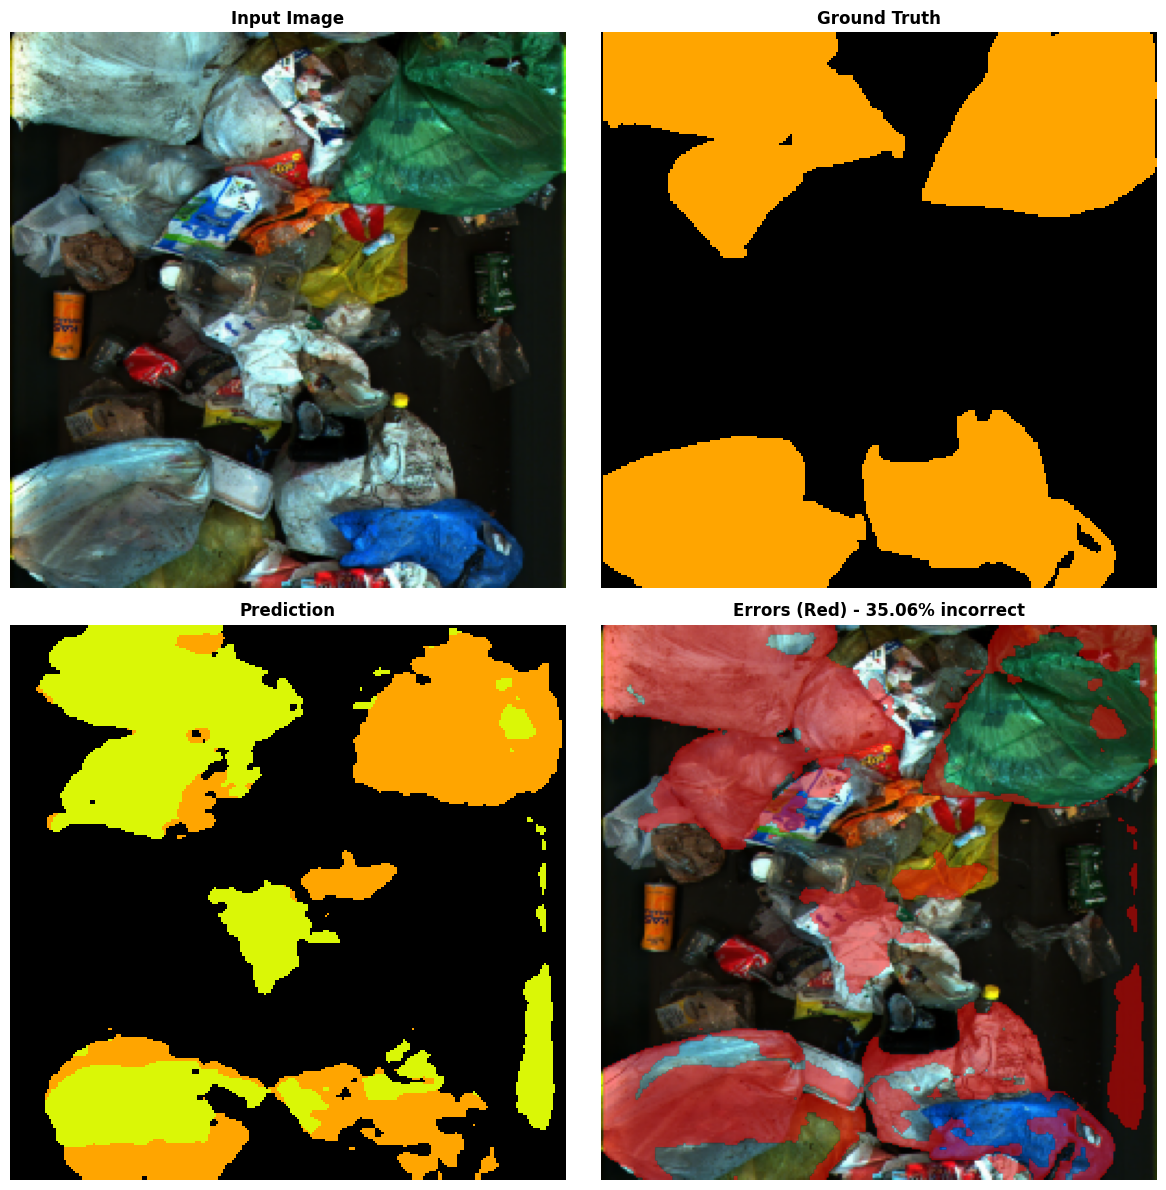

In [18]:
# Visualize errors for a specific sample
visualize_errors(model, test_data, sample_idx, device)

## 10. Class Legend

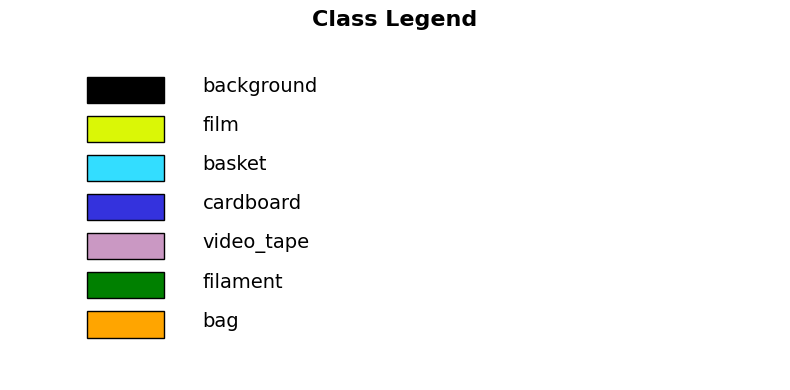

In [19]:
def plot_class_legend(class_names, palette):
    """
    Display a legend showing all classes and their colors.
    """
    fig, ax = plt.subplots(figsize=(8, max(4, len(class_names) * 0.5)))
    ax.axis('off')
    
    y_pos = 0.9
    for i, (name, color) in enumerate(zip(class_names, palette)):
        # Draw color box
        rect = plt.Rectangle((0.1, y_pos - 0.05), 0.1, 0.08, 
                             facecolor=np.array(color)/255, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Add text label
        ax.text(0.25, y_pos, name, fontsize=14, va='center')
        
        y_pos -= 0.12
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Class Legend', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Display legend
plot_class_legend(test_data.classes_names, test_data.palette)